In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [4]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [5]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [6]:
env.render()

|- - X|
|- - -|
|- - -|



In [7]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [8]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [9]:
env.render()

|- - X|
|- O -|
|- - -|



In [10]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [11]:
# env.step((0,2))

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [12]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [13]:
env.reward(player='X')

0

In [14]:
env.reward(player='O')

0

An example of finishing the game:

In [15]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [16]:
env.render()

|X X X|
|O O -|
|- - -|



In [17]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [18]:
env.reward(player='X')

1

In [19]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [20]:
env.reset();

In [21]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [22]:
opt_player.act(env.grid)

(2, 2)

In [23]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [24]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - X|
|- X -|
|X - O|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - -|
|- O X|
|X X O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X - O|
|- X O|
|- - X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O X X|
|X X -|
|O O O|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|- X X|
|O O O|
|- - X|



### An example of optimal player playing against optimal player

In [25]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt_1.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X X O|
|O X O|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|O X O|
|X X O|
|X O X|



# Question 1
In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against
Opt(eps_opt) for some eps_opt ∈ [0, 1]. To do so, implement the Q-learning algorithm. To check the algorithm,
run a Q-learning agent, with a fixed and arbitrary eps ∈ [0, 1), against Opt(0.5) for 20’000 games – switch
the 1st player after every game.
Question 1. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe?
Expected answer: A figure of average reward over time (caption length < 50 words). Specify your choice
of eps.

In [26]:
import random

class QLearntPlayer:
    def __init__(self, game_env: TictactoeEnv, epsilon: float, discount_rate_gamma = 0.99, learning_rate_alpha = 0.5):
        self.game_env = game_env
        self.epsilon = epsilon
        self.discount_rate_gamma = discount_rate_gamma
        self.learning_rate_alpha = learning_rate_alpha
        self.Q_values = {Turns[0]: {}, Turns[1]: {}}
        self.prev_move = None
        self.prev_grid = None
        self.player = None # 'X' or 'O'
        self.player_Q_values = None

    def get_empty_positions(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def hash_grid(self, grid: np.ndarray):
        return grid.tobytes()

    def prepare_new_game_(self, player):
        self.prev_move = None
        self.prev_grid = None
        self.curr_grid = None
        self.curr_move = None
        assert player == 'X' or player == 'O'
        self.player = player
        self.player_Q_values = self.Q_values[player]
        return self

    def get_max_val_action(self, possible_moves, grid_hash):
        if len(possible_moves) == 0:
            q_val = self.player_Q_values[grid_hash]['']
            assert type(q_val) is int
            return ''
        return max(possible_moves, key=self.player_Q_values[grid_hash].get)

    def init_q_values_(self, grid_hash, possible_moves):
        if grid_hash not in self.player_Q_values:
            self.player_Q_values[grid_hash] = {} if len(possible_moves) > 0 else {'': 0}
        for mv in possible_moves:
            if mv not in self.player_Q_values[grid_hash]: self.player_Q_values[grid_hash][mv] = 0

    def choose_move_(self, grid):
        grid_hash = self.hash_grid(grid)
        # Get moves
        possible_moves = self.get_empty_positions(grid)
        assert len(possible_moves) > 0
        # Init Q_values
        self.init_q_values_(grid_hash, possible_moves)
        # Choose move (eps.greedy)
        if random.random() >= self.epsilon:
            chosen_move = self.get_max_val_action(possible_moves, grid_hash)
        else:
            chosen_move = random.choice(possible_moves)
        self.curr_grid = grid
        self.curr_move = chosen_move
        return chosen_move

    def update_q_values_(self, new_grid):
        """
        update Q values by Q-learning formula.

        new_grid ~ S' in the formula
        """
        prev_grid, prev_move = self.prev_grid, self.prev_move
        self.prev_grid = self.curr_grid
        self.prev_move = self.curr_move
        self.curr_grid, self.curr_move = None, None
        if prev_grid is not None and prev_move is not None:
            new_grid_hash = self.hash_grid(new_grid)
            prev_grid_hash = self.hash_grid(prev_grid)
            reward = self.game_env.reward(self.player)
            # Get max_a (Q(S', a))
            possible_moves_s_dash = self.get_empty_positions(new_grid)
            self.init_q_values_(new_grid_hash, possible_moves_s_dash)
            max_val_action = self.get_max_val_action(possible_moves_s_dash, new_grid_hash)
            max_q_value = self.player_Q_values[new_grid_hash][max_val_action]

            # Update according to Q-learning formula
            prev_q_val = self.player_Q_values[prev_grid_hash][prev_move]
            self.player_Q_values[prev_grid_hash][prev_move] += self.learning_rate_alpha*(reward + self.discount_rate_gamma*max_q_value - prev_q_val)

In [27]:
def run_n_games(max_games_number, our_player, opponent_epsilon, our_player_new_game_epsilon, update_q_values, progress_print=None):
    _rewards = [None for _ in range(max_games_number)]
    _turns = ['X','O']
    opponent =  OptimalPlayer(epsilon=opponent_epsilon, player=_turns[0])

    for game in range(max_games_number):
        if progress_print and game % progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent.player = _turns[0]
        our_player = q_learnt_player.prepare_new_game_(_turns[1])
        assert opponent.player != our_player.player
        our_player.epsilon = our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.act(grid)
            else:
                chosen_move = our_player.choose_move_(grid)

            grid, end, winner = env.step(chosen_move, print_grid=False)

            if opponent_turn:
                update_q_values and q_learnt_player.update_q_values_(grid)
            if end:
                update_q_values and q_learnt_player.update_q_values_(grid)
                _rewards[game] = env.reward(our_player.player)
                break
    return _rewards

Game  0  begins.
Game  2500  begins.
Game  5000  begins.
Game  7500  begins.
Game  10000  begins.
Game  12500  begins.
Game  15000  begins.
Game  17500  begins.
Our agent won 6599 times


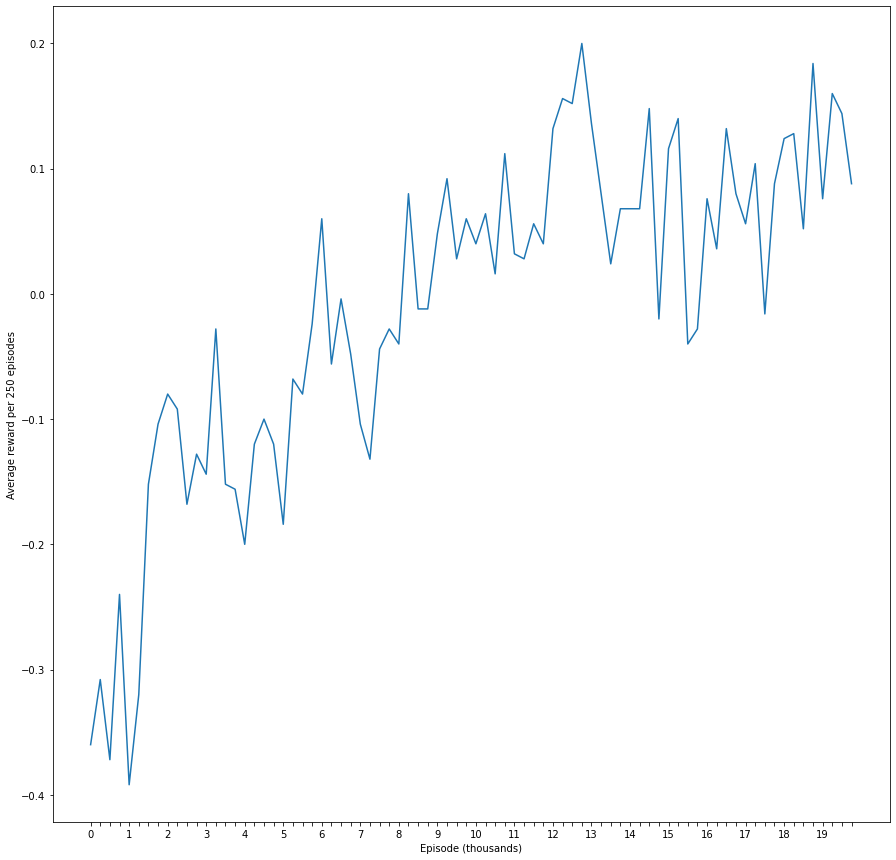

In [28]:
import matplotlib.pyplot as plt

max_games = 20000
q_learnt_player = QLearntPlayer(env, epsilon=0.2)
avgs = []
rewards = []
total_wins = 0

for game_epoch in range(max_games//250):
    if game_epoch % 10 == 0:
        print('Game ', game_epoch*250, ' begins.')
    run_rewards = run_n_games(max_games_number=250, our_player=q_learnt_player, opponent_epsilon=0.5, \
            our_player_new_game_epsilon=lambda game_number_n: 0.2, update_q_values=True)
    rewards+=run_rewards
    avgs.append(np.average(run_rewards))
    total_wins += sum(1 if rew ==1 else 0 for rew in run_rewards)

print('Our agent won {} times'.format(total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(avgs)
plt.xticks(ticks=range(len(avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

Question 2. Plot average reward for every 250 games during training. Does decreasing epsilon help training
compared to having a fixed epsilon? What is the effect of n∗?
Expected answer: A figure showing average reward over time for different values of n∗ (caption length < 200 words)

In [36]:
max_games = 20000
n_stars =  np.geomspace(1, 40000, num=4) # Includes 1 and 40000
epoch_size = 250

rewards = {n_star: [] for n_star in n_stars}
M_opt = {n_star: [] for n_star in n_stars}
M_rand = {n_star: [] for n_star in n_stars}

min_epsilon = 0.1
max_epsilon = 0.8
def calc_epsilon_factory(n_star, epoch_size, game_epoch):
        def calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(min_epsilon, max_epsilon*(1-(real_game_number/n_star)))
        return calc_epsilon

for n_star in n_stars:
    q_learnt_player = QLearntPlayer(env, epsilon=max_epsilon)
    print('Current n_star = {}'.format(n_star))

    for game_epoch in range(max_games//epoch_size):
        calc_epsilon = calc_epsilon_factory(n_star=n_star, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 2)
        run_rewards = run_n_games(max_games_number=epoch_size, our_player=q_learnt_player, opponent_epsilon=0.5, \
            our_player_new_game_epsilon=calc_epsilon, update_q_values=True)
        rewards[n_star] += run_rewards

        # Run 500 games for M_opt calculation
        M_opt_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=0, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_opt[n_star].append(np.average(M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=1, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_rand[n_star].append(np.average(M_rand_rewards))


Current n_star = 1.0
Game  0  begins.


KeyboardInterrupt: 

Text(0, 0.5, 'Average rewards per 250 epochs')

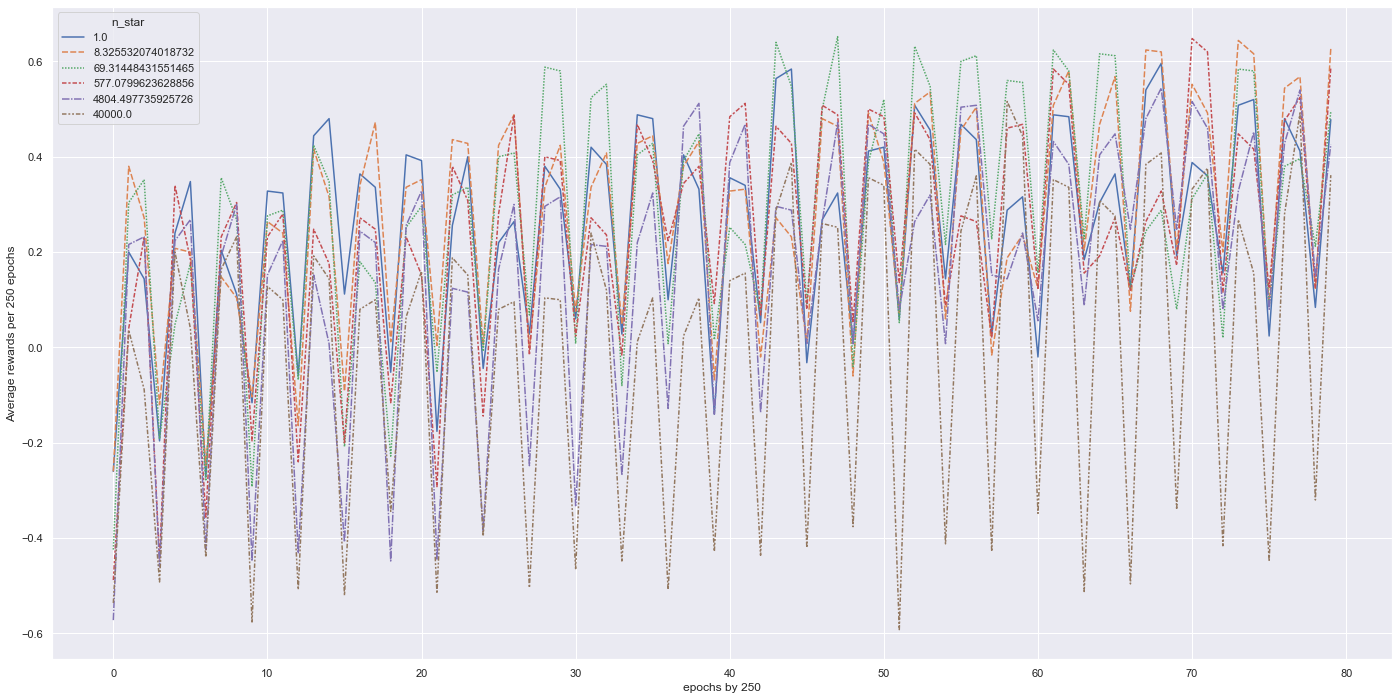

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
avgs = {n_star: [] for n_star in n_stars}
for x in range(0,max_games, 250):
    lower_index = x
    upper_index = min(x+250, max_games-1)
    for n_star in n_stars:
        slice = rewards[n_star][lower_index:upper_index]
        avgs[n_star].append(sum(slice)/len(slice))

q2_data = pd.DataFrame(avgs)
q2_data.index.name = 'epochs by 250'
q2_data.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_data)
g.set_ylabel('Average rewards per 250 epochs')

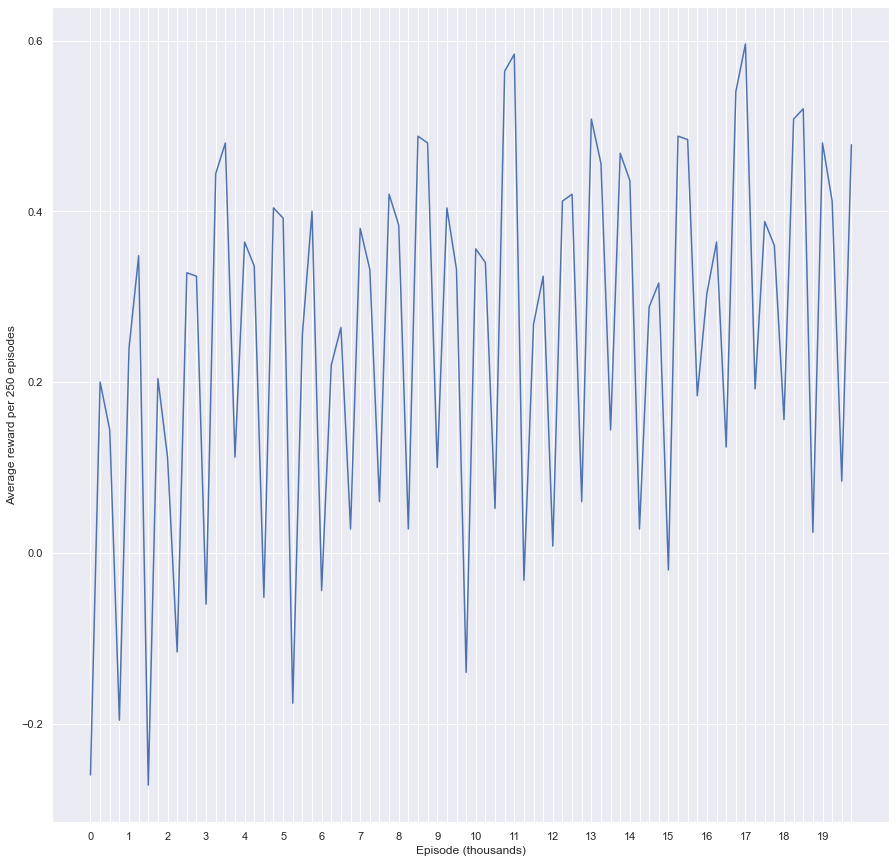

In [ ]:
# Print the same plot as in exe 1 to ensure results are the same

plt.figure(figsize=(15,15))
ax = plt.plot(avgs[1.0])
plt.xticks(ticks=range(len(avgs[1.0])), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs[1.0]))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [ ]:
for (n_star, rews) in rewards.items():
    print('{} won {} games'.format(n_star, sum(1 if rew ==1 else 0 for rew in rews)))

1.0 won 33684 games
8.325532074018732 won 34451 games
69.31448431551465 won 34381 games
577.0799623628856 won 33905 games
4804.497735925726 won 33859 games
40000.0 won 28582 games


In [ ]:
len(rewards[1.0])

60000